In [ ]:
# !pip install category_encoders
# !pip install line_profiler
import os
from google.colab import drive
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
import scipy.stats as sts
import warnings

In [ ]:
warnings.filterwarnings("ignore")
%autosave 60

Autosaving every 60 seconds


In [ ]:
sns.set(style='darkgrid', palette='deep')
plt.rcParams['figure.figsize'] = 15, 9
plt.rcParams['savefig.format'] = 'pdf'

# Итотовая работа по ML
- Подробности на странице на платформе
- Данные в этой работе используются такие же, как и в соревновании по ML (ДЗ 1), за исключением того, что для test датасета мы знаем метку класса "1" или "0". Обновленные данные доступны в соревновании на kaggle (файл называется test_full.csv)

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path_data = '/content/drive/MyDrive/'

# не меняйте название переменных train и test - в которых лежат датасеты train.csv и test_full.csv соответсвенно
# эти файлы будут участвовать в тестировании работы

train = pd.read_csv(path_data + 'train.csv')

# test датасет запрещается видоизменять - применять к нему какую либо логику трансформации
# можно видоизменять входные данные внутри функции def get_score(dict_input) (смотри ниже)

test = pd.read_csv(path_data + 'test_full.csv')

## Место для вашего кода ↓↓↓

## Обучение модели / написание вспомогательно кода ↓↓↓

В качестве модели решил выбрать не самый удачный бустинг (вырожденный в решающее дерево). В нем использовались 4 признака: 3 числовых (заполенение пропусков через медианы) и один категориальный (заполнение пропусков через ```target encoding```). Чтобы несколько ускорить работу модели, обученный ```TargetEncoder``` переводится в словарь. Дополнительно было выявлено, что оптимальнее использовать только часть ```train``` для обучения модели

In [ ]:
Targetenc = TargetEncoder().fit(X=train.pack, y=train.binary_target)
target_enc_df = Targetenc.transform(X=train["pack"])
target_enc_df["pack_name"] = train.pack
target_enc_dict = {}
for i in range(target_enc_df.shape[0]):
    t = target_enc_df.iloc[i]
    if t["pack_name"]:
        target_enc_dict[t["pack_name"]] = t["pack"]
target_enc_dict["nan"] = 0.391745

In [ ]:
cols = ["pack", "сумма", "on_net", "секретный_скор"]
features_medians = {"сумма": 0, "on_net": 0, "секретный_скор": 0}
train_cut = train.loc[:, cols + ["binary_target"]]
for feature in ["сумма", "on_net", "секретный_скор"]:
    # запомним медианы
    features_medians[feature] = train[feature].median()
    train_cut[feature].fillna(features_medians[feature], inplace=True)
train_cut['pack'] = Targetenc.transform(X=train.pack)

In [ ]:
best_params = {'learning_rate': 0.9759401364080774, 'n_estimators': 1, 'max_depth': 4, 'reg_alpha': 3.643464341091844, 'reg_lambda': 15.616003689443925}
X_train, _, y_train, _ = train_test_split(train_cut.drop(columns=['binary_target']), train_cut.binary_target, test_size=0.2, random_state=1)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
clf_boost = LGBMClassifier(random_state=42, **best_params, verbosity=-1, n_jobs=1)
clf_boost.fit(
    X=X_train,
    y=y_train
)

LGBMClassifier(learning_rate=0.9759401364080774, max_depth=4, n_estimators=1,
               n_jobs=1, random_state=42, reg_alpha=3.643464341091844,
               reg_lambda=15.616003689443925, verbosity=-1)

## код логики production функции ↓↓↓
__Ограничение на число CPU в модели внутри функции def get_score - 1 ядро, это означает что нужно ставить следующие параметры (Модель должна на одном CPU)__
Если вы обучались на нескольких ядрах (или GPU) - поменяйте параметры в уже обученной модели, чтобы в production она использовала только одно ядро

- это нужно явно показать в коде
- для уже обученных моделей:
- для catboost - model.predict(thread_count=1)
- для lightgbm - model.set_params(n_jobs=1) и затем model.get_params().get('n_jobs')
- для xgboost - model.set_params(n_jobs=1) и затем model.get_params()['n_jobs']
- для других классификаторов смотрите документацию



In [ ]:
def get_score(dict_input):
    # заполнение числовых пропусков медианами
    for feature in features_medians.keys():
        if np.isnan(dict_input[feature]):
            dict_input[feature] = features_medians[feature]
    # заполнение категориального пропуска
    if dict_input["pack"] in target_enc_dict.keys():
        dict_input["pack"] = target_enc_dict[dict_input["pack"]]
    else:
        dict_input["pack"] = target_enc_dict["nan"]
    # перевод признаков в массив (работает чутка быстрее, чем с DataFrame)
    arr_input_ = [dict_input[col] for col in cols]
    # прогноз и возврат в требуемом формате
    binary_prediction = clf_boost.predict([arr_input_])[0]
    return {
        "client_id": dict_input['client_id'],
        "prediction": binary_prediction,
    }

In [ ]:
row_input = {
    'client_id': 1010348,
    'регион': 'Нептун',
    'использование': '>24LY',
    'сумма': 31.69021931132696,
    'частота_пополнения': 16.0,
    'доход': 42653.164535362455,
    'сегмент_arpu': 441.45,
    'частота': 4.242640687119285,
    'объем_данных': 32.01562118716424,
    'on_net': np.nan,
    'продукт_1': 12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': False,
    'секретный_скор': 0.6065573770491803,
    'pack': 'трафик: 100 (условие) 40mb,_сутки',
    'pack_freq': 3.0,
    'binary_target': 0
}
%load_ext line_profiler
%lprun -f get_score get_score(row_input)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


______
## Тут нужно написать код для пятого пункта дз ↓↓↓

Так как мы не знаем истинных разметок таргета, то остается лишь отслеживать качество модели через стабильность работы; будем считать, что модель работает корректно, если:

1)  **Распределение подаваемых признаков сохраняется во времени**. Для этого достаточно будет посчитать какую-нибудь метрику расстояния между двумя распределенями, например PSI. Кроме того, так как мы предполагаем онлайн-мониторинг, то рассчет PSI следует делать через определенные интервалы (чтобы, в случае чего оперативно принять меры по исправлению); логичнее было бы делать это через определенные промежутки времени, но в нашем случае это невозможно. Поэтому будет производить замеры PSI каждые 10 000 обработанных записей

2)  **Распределение предсказаний так же сохраняется во времени по отношению к аналогичному распределению на обучающей выборке**. В силу бинарности таргета, в данном случае достаточно будет построения графика изменения среднего прогноза с доверительным интервалом - пока среднее прогнозов на тренировочной выборке попадает в доверительный интервал, то можно говорит о стабильности работы модели

Для начала, выведем графики из первого пункта

In [ ]:
def empiric_pdf(data, range, bins=10):
    """Функция расчета эмпирической функции распределения"""
    return np.histogram(data, bins, range=range)[0] / data.shape[0]


def KL_dist(a, b):
    """Функция расчета расстояния Кульбака-Лейблера"""
    return np.sum(a * np.where(a * b != 0, np.log(a / b), 0))


def PSI(a, b):
    """Функция расчета индекса PSI"""
    return KL_dist(a, b) + KL_dist(b, a)

In [ ]:
# Словарь со всеми необходимыми данными для мониторинга
data = {
    col: {
        "pdf_exp": empiric_pdf(train_cut[col], [train_cut[col].min(), train_cut[col].max()]),
        "range": [train_cut[col].min(), train_cut[col].max()],
        "psi": [],
        "psi_cum": [],
        "features": [],
        "features_cum": []
    }
    for col in cols
}
# Список предсказанных меток для мониторинга
preds = []
i = 0
for row in tqdm(test.itertuples(index=False), total=len(test)):
    dict_input_ = {
        "client_id": row.client_id,
        "регион": row.регион,
        "использование": row.использование,
        "сумма": row.сумма,
        "частота_пополнения": row.частота_пополнения,
        "доход": row.доход,
        "сегмент_arpu": row.сегмент_arpu,
        "частота": row.частота,
        "объем_данных": row.объем_данных,
        "on_net": row.on_net,
        "продукт_1": row.продукт_1,
        "продукт_2": row.продукт_2,
        "зона_1": row.зона_1,
        "зона_2": row.зона_2,
        "mrg_": row.mrg_,
        "секретный_скор": row.секретный_скор,
        "pack": row.pack,
        "pack_freq": row.pack_freq,
    }
    score_result = get_score(dict_input_)
    # Запоминаем значения признаков и прогноз
    preds.append(score_result['prediction'])
    i += 1
    for col in cols:
        data[col]["features"].append(dict_input_[col])
        data[col]["features_cum"].append(dict_input_[col])
    # Если накопали достаточно записей, то считаем PSI
    if i % 10_000 == 0:
        for col in cols:
            data[col]["psi_cum"].append(
                PSI(
                    data[col]["pdf_exp"],
                    empiric_pdf(np.array(data[col]["features_cum"]), data[col]["range"])
                    )
                )
            data[col]["psi"].append(
                PSI(
                    data[col]["pdf_exp"],
                    empiric_pdf(np.array(data[col]["features"]), data[col]["range"])
                    )
                )
            data[col]["features"] = []
# Если осталось достаточное количество необработанных записей, то для них также можно посчитать PSI
if len(data['секретный_скор']['features']) > 1000:
    for col in cols:
        data[col]["psi_cum"].append(
            PSI(
                data[col]["pdf_exp"],
                empiric_pdf(np.array(data[col]["features_cum"]), data[col]["range"])
                )
            )
        data[col]["psi"].append(
            PSI(
                data[col]["pdf_exp"],
                empiric_pdf(np.array(data[col]["features"]), data[col]["range"])
                )
            )

100%|██████████| 497586/497586 [07:55<00:00, 1046.24it/s]


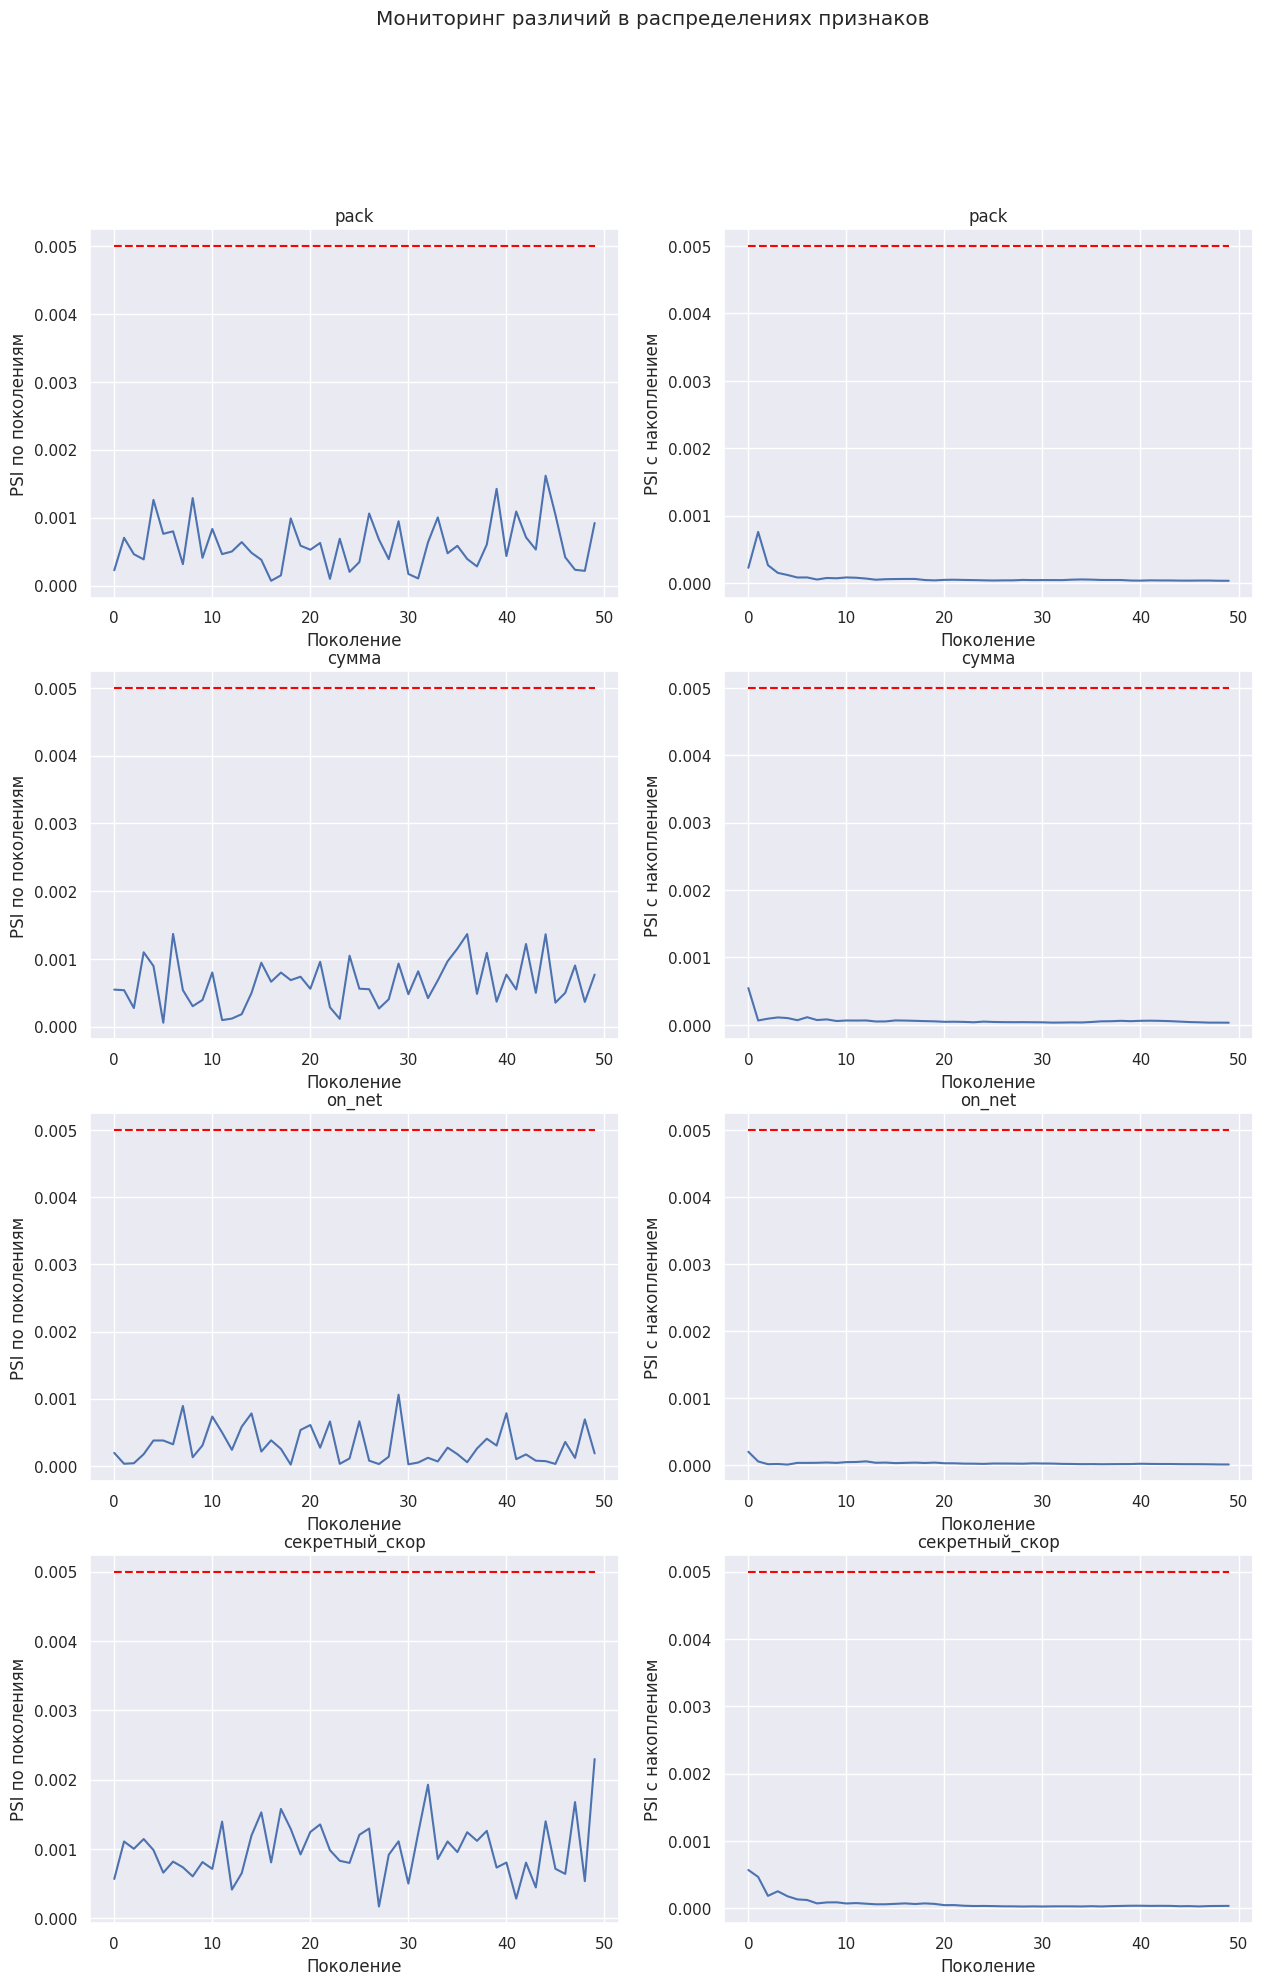

In [ ]:
# Отрисовываем графики изменения PSI по поколениям
fig, axs = plt.subplots(4, 2)
fig.suptitle('Мониторинг различий в распределениях признаков')
fig.set_figheight(22)
fig.set_figwidth(15)
for i in range(len(cols)):
    axs[i, 0].plot(data[cols[i]]["psi"])
    axs[i, 0].set_title(f'{cols[i]}')
    axs[i, 0].set_xlabel("Поколение")
    axs[i, 0].set_ylabel("PSI по поколениям")
    axs[i, 0].hlines(0.005, 0, len(data[cols[i]]["psi"]) - 1, linestyles='dashed', color='red')

    axs[i, 1].plot(data[cols[i]]["psi_cum"])
    axs[i, 1].set_title(f'{cols[i]}')
    axs[i, 1].set_xlabel("Поколение")
    axs[i, 1].set_ylabel("PSI с накоплением")
    axs[i, 1].hlines(0.005, 0, len(data[cols[i]]["psi_cum"]) - 1, linestyles='dashed', color='red')

По графикам видно, что PSI всегда нахдится ниже отметки в 0.005 (что на деле является крайне консервативной оценкой наличия отличий в распределениях). Следовательно, поступаемые на вход признаки **не имеют существенных отличий** от тех, что использовались в обучении

Теперь перейдем ко второму пункту

In [ ]:
def confedence_interval(rvs, alpha=0.05):
    """
        Построение точного доверительного интервала для среднего значения по выборке rvs на уровне доверия 1 - alpha
    """
    n = rvs.shape[0]
    t_crit = sts.t.ppf(1 - alpha / 2, df=n-1, loc=0, scale=1)  # Получение необходимой квантили стандартного нормального распределения
    left = rvs.mean() - t_crit * np.sqrt(rvs.var(ddof=1) / n)  # Расчет левой границы интервала
    right = rvs.mean() + t_crit * np.sqrt(rvs.var(ddof=1) / n)  # Расчет правой границы интервала
    return left, right

In [ ]:
# Рассчитываем среднее и доверительные интервалы по прогнозам
intervals = []
means = []
intervals_cum = []
means_cum = []
step = 10_000
for i in range(0, len(preds), step):
    t = preds[i: i + step]
    means.append(np.mean(t))
    intervals.append(confedence_interval(np.array(t)))
    t = preds[0: i + step]
    means_cum.append(np.mean(t))
    intervals_cum.append(confedence_interval(np.array(t)))
intervals = np.array(intervals)
intervals_cum = np.array(intervals_cum)

In [ ]:
# Считаем средний прогноз на обучении
preds_train = clf_boost.predict(X_train)

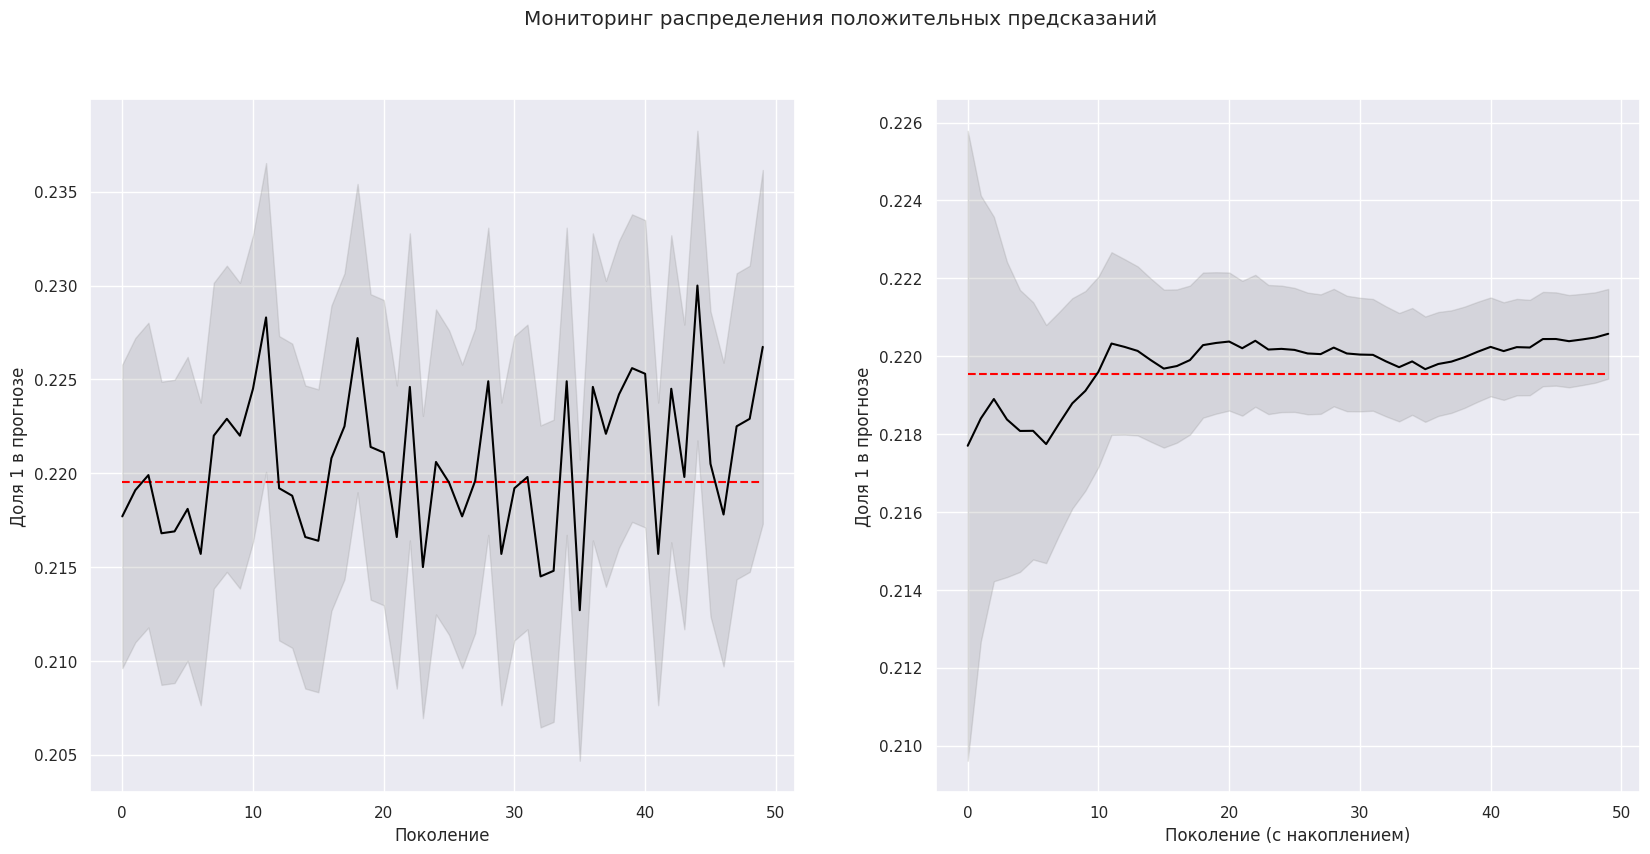

In [ ]:
# Отрисовываем график изменения среднего прогноза по поколениям
fig, axs = plt.subplots(1, 2)
fig.suptitle('Мониторинг распределения положительных предсказаний')
fig.set_figwidth(20)
axs[0].set_xlabel('Поколение')
axs[0].set_ylabel('Доля 1 в прогнозе')
axs[0].hlines(
    preds_train.mean(), 0, len(preds) / step - 1,
    linestyles='dashed', color='red'
)
axs[0].plot(np.arange(0, len(preds) / step), means, color='black')
axs[0].fill_between(
    np.arange(0, len(preds) / step),
    intervals[:, 0], intervals[:, 1], color='grey', alpha=.2
)
axs[1].set_xlabel('Поколение (с накоплением)')
axs[1].set_ylabel('Доля 1 в прогнозе')
axs[1].hlines(
    preds_train.mean(), 0, len(preds) / step - 1,
    linestyles='dashed', color='red'
)
axs[1].plot(np.arange(0, len(preds) / step), means_cum, color='black')
axs[1].fill_between(
    np.arange(0, len(preds) / step),
    intervals_cum[:, 0], intervals_cum[:, 1], color='grey', alpha=.2
)
plt.show()

По графикам видно, что распределение предсказаний на обучении практически всегда попадает в доверительный интервал предсказаний на тесте. Однако на правом графике впрослеживается устойчивая тенденция к сдвигу доли положительных предсказаний на обучении к нижней границе интервала; это может быть сигналом к потенциальной смещенности в прогнозах, а значит и необходимости внесения в модель изменений в ближайшем будущем

## Автоматические проверки работы ↓↓↓
### Этот код менять нельзя, иначе проверки в ноутбуке могут сломаться

## тест 1: проверка input модели (1)

In [ ]:
row_input = {
    'client_id': 1010348,
    'регион': 'Нептун',
    'использование': '>24LY',
    'сумма': 31.69021931132696,
    'частота_пополнения': 16.0,
    'доход': 42653.164535362455,
    'сегмент_arpu': 441.45,
    'частота': 4.242640687119285,
    'объем_данных': 32.01562118716424,
    'on_net': np.nan,
    'продукт_1': 12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': False,
    'секретный_скор': 0.6065573770491803,
    'pack': 'трафик: 100 (условие) 40mb,_сутки',
    'pack_freq': 3.0,
    'binary_target': 0
}

In [ ]:
# если завершилось без ошибок - тест пройден
get_score(row_input)

{'client_id': 1010348, 'prediction': 0}

## тест 2: проверка input модели (2)

In [ ]:
row_input = {
    'client_id': -999,
    'регион': 'Калифорния',
    'использование': '<2года',
    'сумма': -999,
    'частота_пополнения': -16.0,
    'доход': -42653.164535362455,
    'сегмент_arpu': -441.45,
    'частота': 0.1,
    'объем_данных': -1,
    'on_net': np.nan,
    'продукт_1': -12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': True,
    'секретный_скор': -0.6065573770491803,
    'pack': 'трафик Тройное условие 123',
    'pack_freq': -3.0,
    'binary_target': -0.1
}

In [ ]:
# если завершилось без ошибок - тест пройден
get_score(row_input)

{'client_id': -999, 'prediction': 1}

## тест 3: проверка output модели

In [ ]:
get_score_result = get_score(row_input)

In [ ]:
# если завершилось без ошибок - тест пройден
assert get_score_result['prediction'] in [0, 1]

In [ ]:
# если завершилось без ошибок - тест пройден
assert not bool(set(get_score_result.keys()) - set(['client_id', 'prediction']))

## тест 4: мониторинг времени (1)
- зеленый цвет названия графика означает - что тест пройден
- красный цвет названия графика означает - что тест не пройден

In [ ]:
%%time
# тут ничего менять не нужно
times = []
preds = []
for row in tqdm(test.itertuples(index=False), total=len(test)):
    dict_input_ = {
        "client_id": row.client_id,
        "регион": row.регион,
        "использование": row.использование,
        "сумма": row.сумма,
        "частота_пополнения": row.частота_пополнения,
        "доход": row.доход,
        "сегмент_arpu": row.сегмент_arpu,
        "частота": row.частота,
        "объем_данных": row.объем_данных,
        "on_net": row.on_net,
        "продукт_1": row.продукт_1,
        "продукт_2": row.продукт_2,
        "зона_1": row.зона_1,
        "зона_2": row.зона_2,
        "mrg_": row.mrg_,
        "секретный_скор": row.секретный_скор,
        "pack": row.pack,
        "pack_freq": row.pack_freq,
    }
    # оценка времени работы функции скоринга
    stime = time.time()
    score_result = get_score(dict_input_)
    times.append((time.time() - stime))
    # сохранение предиктов для будущей оценки
    preds.append(score_result['prediction'])
times = np.array(times) * 1000

100%|██████████| 497586/497586 [07:32<00:00, 1099.85it/s]

CPU times: user 7min 10s, sys: 4.35 s, total: 7min 14s
Wall time: 7min 32s


#### Отрисовка оценки времени работы

Запуск осуществлялся в колабе и на локальном юпитере. В colab отрабатывало медленнее почти в 10 раз. На всякий случай прилагаю графики времени работы обоих вариантов (специально сделал их стилистически различными)

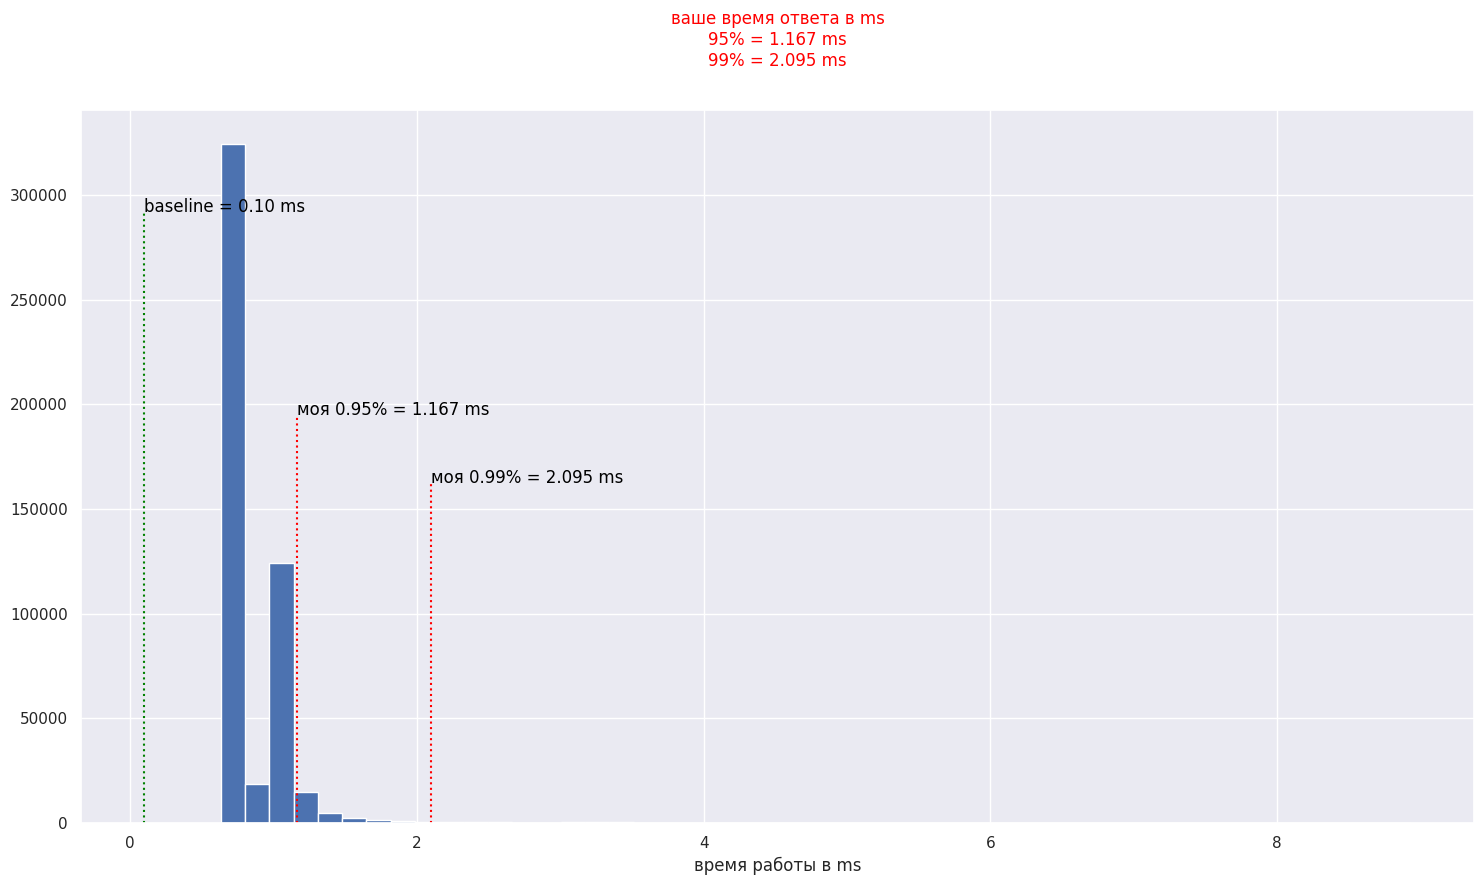

In [ ]:
plt_vals = plt.hist(times, bins=np.linspace(np.quantile(times, 0.001), np.quantile(times, 0.999)))
plt.vlines(0.10, 0, plt_vals[0].max() * 0.9, color='green', linestyle=':')
plt.text(0.10, plt_vals[0].max() * 0.9, s='baseline = 0.10 ms', color='black', rotation=0)
plt.vlines(np.quantile(times, 0.95), 0, plt_vals[0].max() * 0.6, color='red', linestyle=':')
plt.vlines(np.quantile(times, 0.99), 0, plt_vals[0].max() * 0.5, color='red', linestyle=':')
plt.text(
    np.quantile(times, 0.95), plt_vals[0].max() * 0.6,
    s=f'моя 0.95% = {np.quantile(times, 0.95):0.3f} ms', color='black', rotation=0
)
plt.text(
    np.quantile(times, 0.99), plt_vals[0].max() * 0.5,
    s=f'моя 0.99% = {np.quantile(times, 0.99):0.3f} ms', color='black', rotation=0
)
plt.title(
    f'ваше время ответа в ms\n95% = {np.quantile(times, 0.95):0.3f} ms\n99% = {np.quantile(times, 0.99):0.3f} ms',
    y=1.05,
    color=(
        'green'
        if (round(np.quantile(times, 0.95), 3) <= 0.10) & (round(np.quantile(times, 0.99), 3) <= 0.10)
        else 'red'
    )
)
plt.xlabel('время работы в ms')
plt.tight_layout()
plt.show()

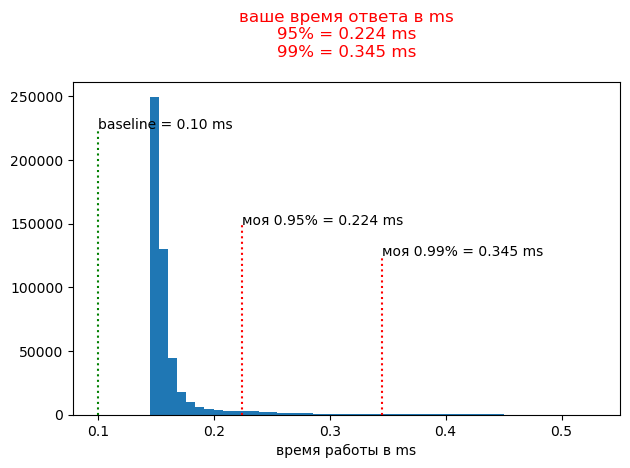

In [ ]:
plt_vals = plt.hist(times, bins=np.linspace(np.quantile(times, 0.001), np.quantile(times, 0.999)))
plt.vlines(0.10, 0, plt_vals[0].max() * 0.9, color='green', linestyle=':')
plt.text(0.10, plt_vals[0].max() * 0.9, s='baseline = 0.10 ms', color='black', rotation=0)
plt.vlines(np.quantile(times, 0.95), 0, plt_vals[0].max() * 0.6, color='red', linestyle=':')
plt.vlines(np.quantile(times, 0.99), 0, plt_vals[0].max() * 0.5, color='red', linestyle=':')
plt.text(
    np.quantile(times, 0.95), plt_vals[0].max() * 0.6,
    s=f'моя 0.95% = {np.quantile(times, 0.95):0.3f} ms', color='black', rotation=0
)
plt.text(
    np.quantile(times, 0.99), plt_vals[0].max() * 0.5,
    s=f'моя 0.99% = {np.quantile(times, 0.99):0.3f} ms', color='black', rotation=0
)
plt.title(
    f'ваше время ответа в ms\n95% = {np.quantile(times, 0.95):0.3f} ms\n99% = {np.quantile(times, 0.99):0.3f} ms',
    y=1.05,
    color=(
        'green'
        if (round(np.quantile(times, 0.95), 3) <= 0.10) & (round(np.quantile(times, 0.99), 3) <= 0.10)
        else 'red'
    )
)
plt.xlabel('время работы в ms')
plt.tight_layout()
plt.show()

## тест 5: мониторинг времени (2)

In [ ]:
row_input = {
    'client_id': -100,
    'регион': 'Plan_1',
    'использование': '<000',
    'сумма': 0,
    'частота_пополнения': 0.0,
    'доход': np.nan,
    'сегмент_arpu': np.nan,
    'частота': np.nan,
    'объем_данных': np.nan,
    'on_net': np.nan,
    'продукт_1': np.nan,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': True,
    'секретный_скор': 0.0,
    'pack': np.nan,
    'pack_freq': np.nan,
}

In [ ]:
# Это замер в колабе
%%timeit
_ = get_score(row_input)

757 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## тест 6: мониторинг f1 score
- зеленый цвет названия графика означает, что тест пройден
- красный цвет названия графика означает, что тест не пройден

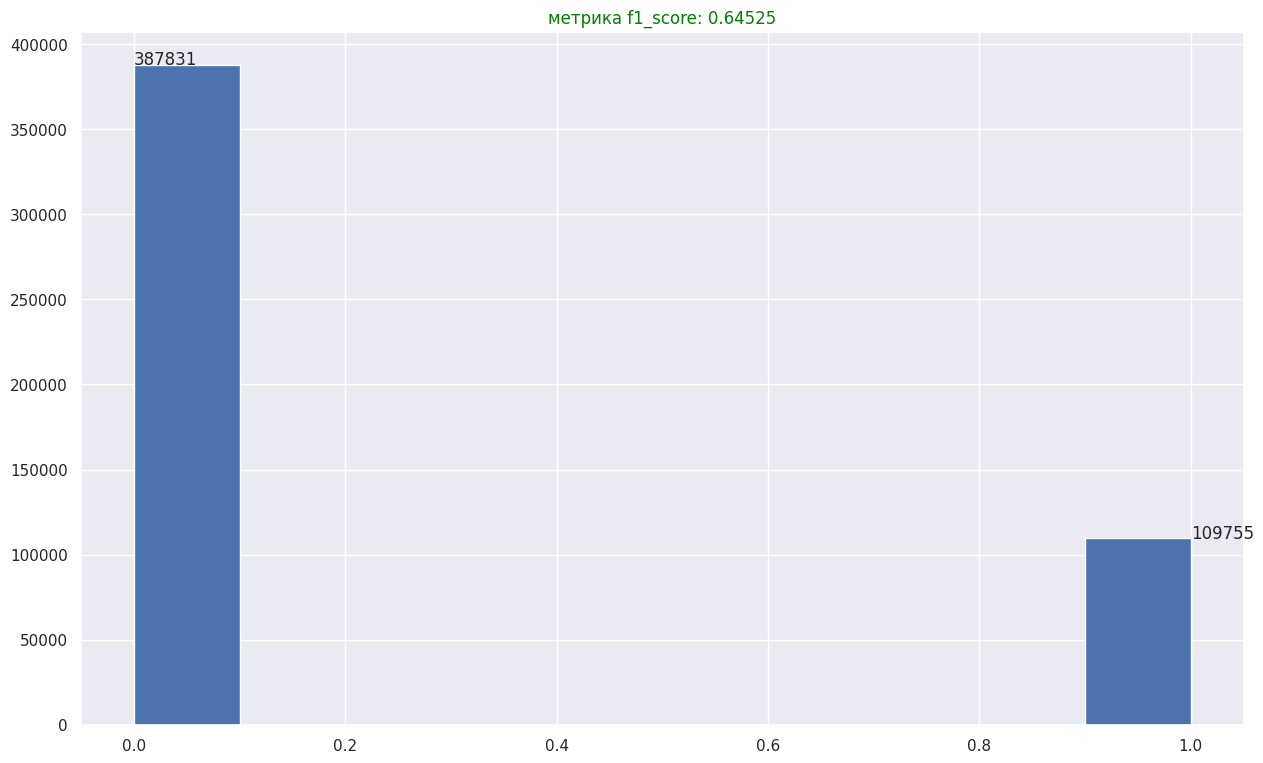

In [ ]:
# Ожидаемая метрика >= 0.6450
plot_vals = plt.hist(preds)
plt.title(
    f"метрика f1_score: {f1_score(test['binary_target'], preds):0.5f}",
    color=('red' if f1_score(test['binary_target'], preds) < 0.6450 else 'green')
)
plt.text(0, plot_vals[0][0], s=f"{plot_vals[0][0]:0.0f}")
plt.text(1, plot_vals[0][-1], s=f"{plot_vals[0][-1]:0.0f}")
plt.show()

## тест 7: Code Style
- воспользуемся библиотекой для оценки качества кода https://github.com/nbQA-dev/nbQA?tab=readme-ov-file#-examples
- нужно установить актуальную версию pip install flake8
- нужно установить актуальную версию pip install -U nbqa
- в отдельной ячейке нужно выполнить команду: !nbqa flake8 ML_итоговая_шаблон.ipynb (см. эту команду ниже)
- поставьте вместо ML_итоговая_шаблон.ipynb ваше название ноутбука
- запрещается менять эту команду, за исключением названия ноутбука

In [ ]:
# Исходная команда проверки не запускалась в Colab, поэтому пришлось напрямую через shell
!nbqa flake8 --extend-ignore=W291,E501 '/content/drive/MyDrive/Colab Notebooks/ML_итог.ipynb' & echo 'everything done'

everything done


In [ ]:
os.system("nbqa flake8 --extend-ignore=W291,E501 '/content/drive/MyDrive/Colab Notebooks/ML_итог.ipynb' & echo 'everything done'")

0

In [ ]:
# ячейка выше должна отпринтовать следующее
# everything done
# 0

# если помимо этого есть и другие строчки - это ошибки по pep8, их нужно исправлять
# например строчка teta_ML_итоговая_шаблон.ipynb:cell_27:1:1: F401 'scipy' imported but unused
# означает, что был бесполезный import scipy, который нигде не использовался

### Если все тесты пройдены успешно, вы можете претендовать на наивысшый балл (⌐■_■)

In [ ]:
print('Ура!')

Ура!
